In [11]:
# IMPORTO I DATI PER VOTTIGNASCO
import os
import numpy as np

# Ottieni il percorso effettivo da una variabile d'ambiente
work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")
v_test_images_dates = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_image_sequences_dates.npy"
v_test_normalization_factors_std_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy")
v_test_normalization_factors_mean_path     = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy")

# Carica l'array numpy dai file
vottignasco_test_OHE    = np.load(v_test_OHE_path)
vottignasco_test_image  = np.load(v_test_image_path)
vottignasco_test_dates  = np.load(v_test_target_dates_path)
vottignasco_test_images_dates = np.load(v_test_images_dates)
vott_target_test_std    = np.load(v_test_normalization_factors_std_path) 
vott_target_test_mean   = np.load(v_test_normalization_factors_mean_path)


print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))
print(vott_target_test_std)
print(vott_target_test_mean)

105
105
105
0.7535387605163045
4.426558334608545


In [2]:
import tensorflow as tf
#from tensorflow.keras import layers, activations, callbacks, models
import numpy as np
import pickle
import os
from keras.models import load_model
from skimage.transform import resize
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sys

# Se vuoi abilitare il dropout a runtime
mc_dropout = True

# Definizione della classe personalizzata doprout_custom
class doprout_custom(tf.keras.layers.SpatialDropout1D):
    def call(self, inputs, training=None):
        if mc_dropout:
            return super().call(inputs, training=True)
        else:
            return super().call(inputs, training=False)

# Percorso della directory su Cineca
base_dir = os.path.join(os.environ['WORK'], "Water_Resources/rise-video/trained_models/seq2val/Vottignasco")
lstm_suffix = 'time_dist_LSTM'

vott_lstm_models = []

def extract_index(filename):
    """Funzione per estrarre l'indice finale dal nome del file."""
    return int(filename.split('_LSTM_')[-1].split('.')[0])

# Trova tutti i file .keras nella cartella e li aggiunge alla lista
for filename in os.listdir(base_dir):
    if lstm_suffix in filename and filename.endswith(".keras"):
        vott_lstm_models.append(os.path.join(base_dir, filename))

# Ordina i modelli in base all'indice finale
vott_lstm_models = sorted(vott_lstm_models, key=lambda x: extract_index(os.path.basename(x)))

# Lista per i modelli caricati
vott_lstm_models_loaded = []

for i, model_lstm_path in enumerate(vott_lstm_models[:10]):  # Prendo i primi 10 modelli ordinati
    #print(f"Caricamento del modello LSTM {i+1}: {model_lstm_path}")

    # Carico il modello con la classe custom
    model = load_model(model_lstm_path, custom_objects={"doprout_custom": doprout_custom})

    # Aggiungo il modello alla lista
    vott_lstm_models_loaded.append(model)

print(vott_lstm_models_loaded)

2025-03-07 22:23:22.402216: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 22:23:23.928680: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-07 22:23:28.382171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-07 22:23:28.385572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-07 22:23:28.932807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

[<keras.src.engine.functional.Functional object at 0x7f503028ce50>, <keras.src.engine.functional.Functional object at 0x7f4b9db78f40>, <keras.src.engine.functional.Functional object at 0x7f4b9d908c70>, <keras.src.engine.functional.Functional object at 0x7f4b9d770f40>, <keras.src.engine.functional.Functional object at 0x7f4b9d7c2950>, <keras.src.engine.functional.Functional object at 0x7f4b9d7db910>, <keras.src.engine.functional.Functional object at 0x7f4b9d68e800>, <keras.src.engine.functional.Functional object at 0x7f4b9d6c9300>, <keras.src.engine.functional.Functional object at 0x7f4b9d54eaa0>, <keras.src.engine.functional.Functional object at 0x7f4b9d54e8c0>]


In [7]:
#### ***Generation Masks (1D): Uniforme***

import numpy as np
from tqdm import tqdm

def generate_masks_1d(N, input_size, seed=42, **kwargs):
    """
    Parametri:
    - input_size: è il nr di time-step -> scalare
    """
    l = kwargs.get("l", 3)  # La lunghezza della small_mask
    p1 = kwargs.get("p1", 0.5)  # Probabilità di attivazione della maschera

    np.random.seed(seed)

    # Genera una maschera 1D casuale (lunghezza = small_mask_length)
    grid = np.random.rand(N, l) < p1
    grid = grid.astype('float32')  # Trasforma in formato float32

    # Crea una struttura per le maschere finali
    masks = np.empty((N, input_size))  # Maschere finali di dimensione (N, H)

    for i in tqdm(range(N), desc='Generating masks'):
        # Calcola i punti di interpolazione
        x = np.linspace(0, l - 1, l)  # Indici della maschera piccola
        new_x = np.linspace(0, l - 1, input_size)  # Nuovi punti per la dimensione H

        # Interpolazione 1D
        interpolated_mask = np.interp(new_x, x, grid[i])  # Interpola la maschera

        # Applica la maschera interpolata alla maschera finale
        masks[i, :] = interpolated_mask

    # Filtra le maschere che sono tutte 0.0
    masks = masks[~(masks == 0).all(axis=1)]  # Filtra lungo l'asse della dimensione 1 (H)

    return masks

#### ***Application Masks***

def multiplicative_uniform_noise_onechannel(images, masks, channel, **kwargs):
    std_zero_value = kwargs.get("std_zero_value", -0.6486319166678826)

    masked = []

    # Itero su tutte le N maschere generate
    for mask in masks:
        masked_images = copy.deepcopy(images)  # Copia profonda delle immagini originali

        for t in range(len(mask)):
          masked_images[t][..., channel] = masked_images[t][..., channel] * mask[t] + (1-mask[t]) * std_zero_value

        masked.append(masked_images)

    return masked

#### ***Prediction with Black-Box***
def ensemble_predict(models, images, x3_exp, batch_size=1000):
    # Assicuriamoci che images sia una lista
    if not isinstance(images, list):
        images = [images]

    len_x3 = len(images)

    # Convertiamo x3_exp in un tensore replicato per ogni immagine
    x3_exp_tensor = tf.convert_to_tensor(x3_exp, dtype=tf.float32)

    # Lista per raccogliere le predizioni finali
    final_preds = []

    # Processamento a batch
    for i in range(0, len_x3, batch_size):
        batch_images = images[i:i + batch_size]
        batch_len = len(batch_images)

        # Conversione batch in tensori
        Y_test = tf.stack([tf.convert_to_tensor(img, dtype=tf.float32) for img in batch_images])
        Y_test_x3 = tf.tile(tf.expand_dims(x3_exp_tensor, axis=0), [batch_len, 1, 1])

        # Raccoglie le predizioni di tutti i modelli per il batch corrente
        batch_preds = []

        for model in models:
            preds = model.predict([Y_test, Y_test_x3], verbose=0)
            batch_preds.append(preds)

        # Converte le predizioni del batch in un tensore e calcola la media
        batch_preds_tensor = tf.stack(batch_preds)
        mean_batch_preds = tf.reduce_mean(batch_preds_tensor, axis=0)

        # Aggiunge le predizioni del batch alla lista finale
        final_preds.extend(mean_batch_preds.numpy())

    return np.array(final_preds)

#### ***Saliency Map***
# Modifica della funzione per calcolare la mappa di salienza introducendo anche -> E[M] cioè il valore atteso delle Maschere

def calculate_saliency_map(weights_array, masks):
    """
    Calcola la mappa di salienza media data una serie di predizioni e maschere.

    :param weights_array: Array di predizioni (numero di maschere x dimensioni predizione).
    :param masks: Array di maschere (numero di maschere x dimensioni maschera).
    :return: Mappa di salienza media.
    """
    sal = []
    for j in range(len(masks)):
        sal_i = weights_array[j] * np.abs(masks[j])
        sal.append(sal_i)

    ev_masks = np.mean(np.abs(masks), axis=0)
    sal = (1/ev_masks) * np.mean(sal, axis=0)  # aggiunta della frazione 1/valore_atteso(maschere)
    return sal

"""#### ***Temporal-RISE: Framework***"""

def rise_temporal_explain_diff_pred(nr_instance, data_test_image, data_test_OHE, models, channel,
                                    N, generate_masks_fn, seed, perturb_instance_fn, calculate_saliency_map_fn, H_station=390.0, **kwargs):
  print(f"############################### RISE-Temporal on Instance #{nr_instance} ###########################")
  instance    = copy.deepcopy(data_test_image[nr_instance])
  x3_instance = copy.deepcopy(data_test_OHE[nr_instance])

  input_size = instance.shape[0]

  masks = generate_masks_fn(N, input_size, seed, **kwargs)
  perturbed_instances = perturb_instance_fn(instance, masks, channel)

  # Predizione su Istanza Originale
  pred_original = ensemble_predict(models, instance, x3_instance)
  # Predizioni su Istanze Perturbate
  preds_masked = ensemble_predict(models, perturbed_instances, x3_instance)

  # Denormalizzazione degli output della black-box
  denorm_pred_original = pred_original * vott_target_test_std + vott_target_test_mean
  denorm_preds_masked  = [pred_masked * vott_target_test_std + vott_target_test_mean for pred_masked in preds_masked]
  # Denormalizzazione degli output con l'altezza della stazione H_station
  denormalized_H_pred_original = H_station - denorm_pred_original
  denormalized_H_preds_masked  = [H_station - denorm_pred_masked for denorm_pred_masked in denorm_preds_masked]

  print(denormalized_H_pred_original)
  print(denormalized_H_preds_masked)

  # Differenza tra predizione originale e perturbata
  diff_pred = [denormalized_H_pred_original - denorm_H_pred for denorm_H_pred in denormalized_H_preds_masked]
  weights = np.concatenate(diff_pred, axis=0)

  # Calcolo della mappa di salienza
  saliency_vector_i = calculate_saliency_map_fn(weights, masks)
  print(f"############### Processo completato. Vettore di salienza generata per Istanza #{nr_instance} ###############")
  return np.squeeze(saliency_vector_i)

In [153]:
nr_instance = 11

N = 1000
l = 12
p = 0.5

seed = 42
channel_prec = 0

models = vott_lstm_models_loaded

instance    = copy.deepcopy(vottignasco_test_image[nr_instance])
x3_instance = copy.deepcopy(vottignasco_test_OHE[nr_instance])

input_size = (instance.shape[0])

saliency_vector_0 = rise_temporal_explain_diff_pred(nr_instance, vottignasco_test_image, vottignasco_test_OHE, models, channel_prec,
                                                    N, generate_masks_1d, seed, multiplicative_uniform_noise_onechannel, calculate_saliency_map, l=l, p=p)



############################### RISE-Temporal on Instance #11 ###########################


Generating masks: 100%|██████████| 1000/1000 [00:00<00:00, 36347.68it/s]


[[384.98697]]
[array([384.23816], dtype=float32), array([384.85992], dtype=float32), array([384.09415], dtype=float32), array([384.3111], dtype=float32), array([384.83347], dtype=float32), array([384.2226], dtype=float32), array([384.16028], dtype=float32), array([384.24823], dtype=float32), array([384.84335], dtype=float32), array([384.45984], dtype=float32), array([384.13962], dtype=float32), array([384.79114], dtype=float32), array([384.49734], dtype=float32), array([384.12552], dtype=float32), array([384.3822], dtype=float32), array([384.88293], dtype=float32), array([384.8444], dtype=float32), array([384.44492], dtype=float32), array([384.37994], dtype=float32), array([384.514], dtype=float32), array([384.14944], dtype=float32), array([384.09518], dtype=float32), array([384.04208], dtype=float32), array([384.82526], dtype=float32), array([384.4479], dtype=float32), array([384.82315], dtype=float32), array([384.14203], dtype=float32), array([384.81192], dtype=float32), array([384.2

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

# Funzione per determinare la stagione in base al giorno dell'anno
def get_season(day):
    spring = np.arange(80, 172)
    summer = np.arange(172, 264)
    fall = np.arange(264, 355)

    if day in spring:
        return 'Spring'
    elif day in summer:
        return 'Summer'
    elif day in fall:
        return 'Autumn'
    else:
        return 'Winter'

season_colors = {
    'Winter': '#AEC6CF',  # Azzurro chiaro
    'Spring': '#77DD77',  # Verde menta
    'Summer': '#FFD700',  # Giallo dorato
    'Autumn': '#FF8C00'   # Arancione scuro
}

def plot_saliency_vector(saliency_vector, test_dates, test_images_dates, instance_number, input_size=104):
    dates = pd.to_datetime(test_images_dates[instance_number])
    tm_days = [date.timetuple().tm_yday for date in dates]
    seasons = [get_season(tm_yday) for tm_yday in tm_days]
    colors = [season_colors[season] for season in seasons]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(np.arange(input_size), saliency_vector, color='black')

    # Evidenzia le stagioni come intervalli
    season_intervals = []
    start = 0
    current_season = seasons[0]

    for j in range(1, input_size):
        if seasons[j] != current_season:
            season_intervals.append((start, j, current_season))
            start = j
            current_season = seasons[j]
    season_intervals.append((start, input_size, current_season))

    max_saliency = min(saliency_vector)
    min_saliency = max(saliency_vector)
    #print(max_saliency, min_saliency)
    text_offset = max_saliency * -0.037  # Aggiunge un po' di spazio sopra il valore massimo

    for start, end, season in season_intervals:
        ax.axvspan(start, end, color=season_colors[season], alpha=0.2)
        ax.text((start + end) / 2, max_saliency + text_offset, season, color=season_colors[season], fontsize=10, ha='center', va='bottom')

    # Seleziona le date a intervalli regolari per i tick dell'asse x
    month_indices = np.linspace(0, input_size - 1, num=12, dtype=int)
    month_labels = [f"{dates[i].strftime('%b')} {dates[i].year}" for i in month_indices]

    ax.set_xticks(month_indices)
    ax.set_xticklabels(month_labels, rotation=45)

    # Linee tratteggiate per separare i time-step
    for i in range(input_size):
        ax.axvline(x=i, color='grey', linestyle='-', alpha=0.1)

    # Impostare i limiti dell'asse y tra il minimo e massimo della saliency
    ax.set_ylim(min_saliency, max_saliency + (max_saliency - min_saliency) * 0.05)  # Padding solo sopra il max

    # Impostare i tick dell'asse y automaticamente in base ai valori della saliency
    ax.yaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))  # Genera tick ragionevoli

    ax.set_title(f"Temporal Saliency Vector for Instance #{instance_number}, Target Date: {test_dates[instance_number][0].astype(str).split('T')[0]}\n(Impact of each week on groundwater level prediction)", pad=26)
    #ax.set_xlabel('Time-step')
    ax.set_ylabel('Saliency score (Relevance of each time-step)')

    fig.subplots_adjust(left=0.1, right=0.9)
    fig.tight_layout()
    plt.show()

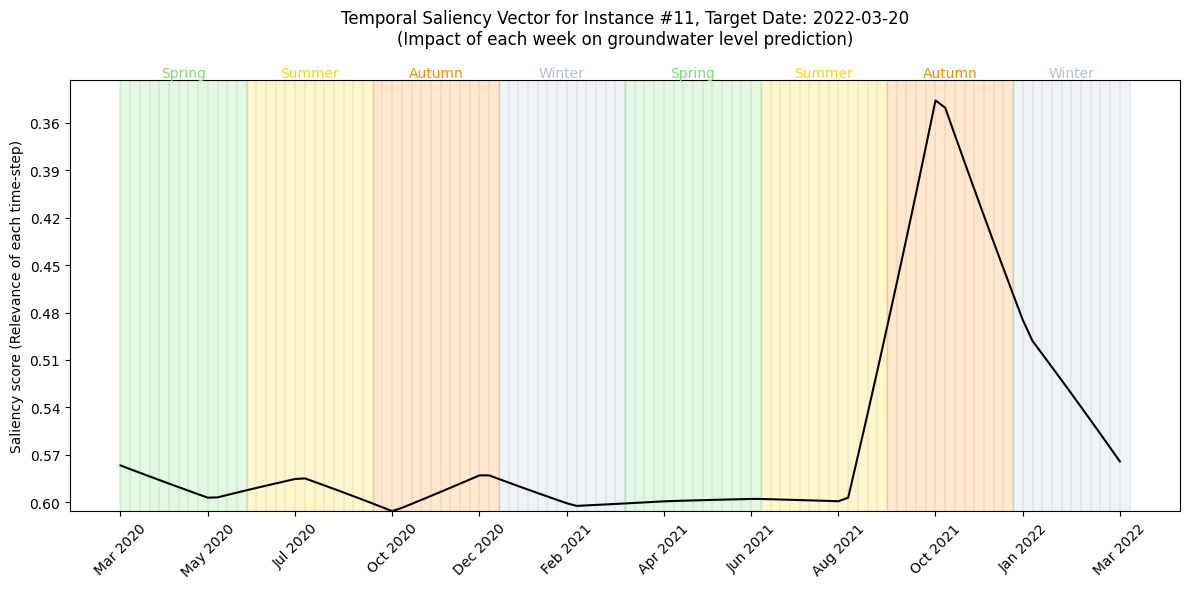

In [157]:
plot_saliency_vector(saliency_vector_0, vottignasco_test_dates, vottignasco_test_images_dates, nr_instance)

In [167]:
#### ***Evaluation Metric***

# Ho implementato anche qui l'approccio a batch per migliorare i tempi di exec

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def calculate_auc(x, y):
    """
    Calcola l'area sotto la curva (AUC) utilizzando il metodo del trapezio.

    :param x: Valori dell'asse x (frazione dei pixel inseriti).
    :param y: Valori dell'asse y (errori calcolati).
    :return: Area sotto la curva.
    """
    return np.trapz(y, x)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def update_image_with_important_frame(current_instance, original_instance, t):
    """
    Aggiorna la current_instance inserendo il t-esimo frame.

    :param current_instance: istanza corrente.
    :param original_instance: istanza originale.
    :param t: nr di frame da inserire in current_instance
    :return: istanza aggiornata.
    """
    new_instance = copy.deepcopy(current_instance)
    new_instance[t,:,:,0] = original_instance[t,:,:,0]
    return new_instance


def insertion(models, original_images, x3, important_indices, initial_blurred_images, original_prediction, H_station=390.0):
    """
    Calcola la metrica di inserimento per una spiegazione data.

    :param models: Lista di modelli pre-addestrati.
    :param original_images: Immagine originale.
    :param x3: Codifica one-hot per la previsione.
    :param important_indices: Indici dei pixel in ordine di importanza.
    :param initial_blurred_images: Immagine iniziale con tutti i pixel a zero.
    :return: Lista degli errori ad ogni passo di inserimento.
    """

    # Predizione originale
    #original_prediction = ensemble_predict(models, original_images, x3)[0]
    #print("Original prediction:", original_prediction)

    # Lista per memorizzare le istanze a cui aggiungo frame mano a mano
    insertion_images = [initial_blurred_images]

    # Predizione sull'immagine iniziale (tutti i pixel a zero)
    I_prime = initial_blurred_images.copy()

    # Aggiungere gradualmente i frames più importanti. Ottengo una lista con tutte le img con i frame in maniera graduale
    for t in important_indices:
        #print(frame)
        I_prime = update_image_with_important_frame(I_prime, original_images, t)
        insertion_images.append(I_prime)

    # Calcolo le predizioni sulle istanze a cui ho aggiunto i frame in maniera graduale
    new_predictions = ensemble_predict(models, insertion_images, x3)
    denorm_new_predictions  = [new_prediction * vott_target_test_std + vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H_station - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]
    # Rispetto ad ogni suddetta predizione, calcolo il MSE rispetto la pred sull'istanza originaria (come da test-set)
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions[1:]]

    initial_error = mean_squared_error(original_prediction, denormalized_H_new_predictions[0]) # mse immagine con tutti i frame blurrati
    print(f"Initial Prediction with ALL Blurred Frame, pred: {denormalized_H_new_predictions[0]}, error: {initial_error}")
    only_inserted_frame_new_predictions = denormalized_H_new_predictions[1:]
    for t, error in enumerate(errors):
      print(f"Frame {important_indices[t]}, new prediction: {only_inserted_frame_new_predictions[t]}, error: {error}")

    total_errors = [initial_error] + errors
    # Normalizzare la frazione di pixel inseriti
    x = np.linspace(0, 1, len(total_errors))
    print("len total erros: ", len(total_errors))

    # Calcolo dell'AUC
    auc = calculate_auc(x, total_errors)
    print(f"Area under the curve (AUC): {auc}")

    # # Plot della curva dell'errore e area sotto la curva (AUC)
    # plt.plot(x, total_errors, label='Error curve')
    # plt.fill_between(x, total_errors, color='skyblue', alpha=0.4)
    # plt.text(x[-1] * 0.95, max(total_errors) * 0.9, f'AUC: {auc:.2f}',
    #      horizontalalignment='right')  # testo a destra
    # plt.xlabel('Fraction of pixels inserted')
    # plt.ylabel('Mean Squared Error')
    # plt.title('Insertion Metric Curve')
    # plt.legend()
    # plt.show()
    return total_errors,auc

def update_image_by_removing_frame(current_instance, t, std_zero_value=-0.6486319166678826):
    """
    Aggiorna l'immagine inserendo i pixel più importanti.

    :param current_instance: Istanza corrente.
    :param original_instance: Istanza originale.
    :param t: nr frame da rimuovere.
    :return: Istanza aggiornata con il superpixel.
    """
    new_current_instance = current_instance.copy()
    new_current_instance[t,:,:,0] = std_zero_value
    return new_current_instance

def deletion(models, original_images, x3, important_indices, original_prediction, H_station=390.0):
    """
    Calcola la metrica di rimozione per una spiegazione data.

    :param models: Lista di modelli pre-addestrati.
    :param original_images: Immagine originale.
    :param x3: Codifica one-hot per la previsione.
    :param important_indices: Indici dei pixel in ordine di importanza.
    :return: Lista degli errori ad ogni passo di rimozione.
    """

    # Lista per memorizzare le img a cui elimino gradualmente frames
    deletions_images = []

    # Inizializzazione
    I_prime = original_images.copy()

    # Rimuovere gradualmente i frames più importanti
    for t in important_indices:
        I_prime = update_image_by_removing_frame(I_prime, t)
        deletions_images.append(I_prime)

    # Calcolo della predizione su tutte le img a cui rimuovo gradualmente in frames
    new_predictions = ensemble_predict(models, deletions_images, x3)
    denorm_new_predictions  = [new_prediction * vott_target_test_std + vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H_station - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]
    # Calcolo del mse rispetto la predizione originale
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions]

    initial_error = 0.0
    print(f"Initial Prediction with Original Images, prediction: {original_prediction}, error: {initial_error}")
    for t, error in enumerate(errors):
      print(f"Removed frame {important_indices[t]}, new prediction: {denormalized_H_new_predictions[t]}, error: {error}")

    total_errors = [initial_error] + errors # Errore iniziale + errori su tutti i pixel rimossi

    # Normalizzare la frazione di pixel rimossi
    x = np.arange(len(total_errors)) / len(total_errors)

    # Calcolo dell'AUC
    auc = calculate_auc(x, total_errors)
    print(f"Area under the curve (AUC): {auc}")

    # # Plot della curva dell'errore e area sotto la curva (AUC)
    # plt.plot(x, total_errors, label='Error curve')
    # plt.fill_between(x, total_errors, color='lightcoral', alpha=0.4)
    # # Posiziona il testo AUC alla destra del titolo
    # plt.text(1.02, 1.02, f'AUC: {auc:.2f}',
    #      horizontalalignment='left',
    #      transform=plt.gca().transAxes,  # Coordinate rispetto all'asse (da 0 a 1)
    #      fontsize=11)
    # plt.xlabel('Fraction of pixels removed')
    # plt.ylabel('Mean Squared Error')
    # plt.title('Deletion Metric Curve')
    # plt.legend()
    # plt.show()
    return total_errors,auc

In [170]:
def plot_insertion_curve(total_errors, auc, title="Insertion Metric Curve"):
    """
    Plotta la curva di metrica di insertion con l'errore medio quadratico.

    :param total_errors: Lista dei valori dell'errore per ogni frazione di pixel inseriti.
    :param auc: Valore dell'Area Under Curve (AUC) calcolato.
    :param title: Titolo del grafico (default: "Insertion Metric Curve").
    """

    # Nuovo asse X normalizzato tra 0 e 1
    x = np.linspace(0, 1, len(total_errors))

    # Plot della curva dell'errore e dell'area sotto la curva (AUC)
    plt.figure(figsize=(7, 5))
    plt.plot(x, total_errors, marker='o', linestyle='-', color='blue')

    # Pallini blu sui punti della curva
    plt.scatter(x, total_errors, color='blue', zorder=3)

    # Area sotto la curva
    plt.fill_between(x, total_errors, color='skyblue', alpha=0.4)

    # Testo "Error curve" in alto a dx con font più piccolo
    plt.legend(['Error curve'], loc='upper right', fontsize=9)

    # Testo AUC appena sotto "Error curve"
    plt.text(x[-1] - 0.02, max(total_errors) * 0.9,
             f'AUC: {auc:.2f}',
             horizontalalignment='right',
             fontsize=8,
             bbox=dict(facecolor='white', alpha=0.5))

    # Etichette assi
    plt.xlabel('Fraction of pixels inserted')
    plt.ylabel('Mean Squared Error')

    # Titolo del grafico
    plt.title(title)

    # Mostra il grafico
    plt.show()


def plot_deletion_curve(total_errors, auc, title="Deletion Metric Curve"):
    """
    Plotta la curva della metrica di deletion con l'errore medio quadratico.

    :param total_errors: Lista dei valori dell'errore per ogni frazione di pixel rimossi.
    :param auc: Valore dell'Area Under Curve (AUC) calcolato.
    :param title: Titolo del grafico (default: "Deletion Metric Curve").
    """

    # Normalizzazione dell'asse X tra 0 e 1
    x = np.linspace(0, 1, len(total_errors))

    # Creazione del plot
    plt.figure(figsize=(7,5))
    plt.plot(x, total_errors, marker='o', linestyle='-', color='red')

    # Pallini rossi sui punti della curva
    plt.scatter(x, total_errors, color='red', zorder=3)

    # Area sotto la curva
    plt.fill_between(x, total_errors, color='lightcoral', alpha=0.4)

    # Testo "Error curve" in alto a sx con font più piccolo
    plt.legend(['Error curve'], loc='upper left', fontsize=9)

    # Testo AUC appena sotto "Error curve"
    plt.text(x[0] + 0.01, max(total_errors) * 0.88,
             f'AUC: {auc:.2f}',
             horizontalalignment='left',
             fontsize=8,
             bbox=dict(facecolor='white', alpha=0.5))

    # Etichette degli assi
    plt.xlabel('Fraction of pixels removed')
    plt.ylabel('Mean Squared Error')

    # Titolo del grafico
    plt.title(title)

    # Mostra il grafico
    plt.show()

In [165]:
saliency_vector_i = saliency_vector_0

print(saliency_vector_i)

print(np.argsort(saliency_vector_i)[:])


[0.57676359 0.57909764 0.58141446 0.58371422 0.58599713 0.58826336
 0.59051309 0.59274651 0.59496379 0.59716511 0.59698237 0.59546033
 0.59395853 0.59247657 0.59101406 0.58957061 0.58814586 0.58673945
 0.58535102 0.58494796 0.58714747 0.58937178 0.59162133 0.59389654
 0.59619785 0.59852573 0.60088062 0.60326301 0.60567337 0.60362791
 0.60111823 0.59859047 0.59604441 0.59347987 0.59089664 0.58829451
 0.58567329 0.58303275 0.58307394 0.58534572 0.58759702 0.58982813
 0.5920393  0.59423082 0.59640293 0.5985559  0.60068998 0.60236813
 0.60206806 0.60176303 0.60145292 0.60113759 0.60081692 0.60049077
 0.60015899 0.59982144 0.59947797 0.5992653  0.59908716 0.59891396
 0.59874549 0.59858156 0.59842199 0.59826662 0.59811527 0.59796779
 0.59796889 0.59814562 0.59832347 0.59850247 0.59868263 0.59886394
 0.59904644 0.59923012 0.599415   0.59720474 0.57083138 0.54408571
 0.51695977 0.48944539 0.46153418 0.43321748 0.4044864  0.37533177
 0.34574416 0.35033021 0.36769206 0.38488891 0.40192308 0.4187

In [ ]:
std_zero_value = -0.6486319166678826
saliency_vector_i = saliency_vector_0
H_station = 390.0

# Insertion
initial_blurred_instance = copy.deepcopy(instance)
initial_blurred_instance[:,:,:,channel_prec] = std_zero_value
all_important_frames = np.argsort(saliency_vector_i)[:] # Importanza max per valori prossimi allo 0

original_instance = copy.deepcopy(instance)
original_prediction = ensemble_predict(models, original_instance, x3_instance)
denormalized_H_original_prediction = H_station - (original_prediction * vott_target_test_std + vott_target_test_mean)

print(f"Original Prediction: {denormalized_H_original_prediction}")
errors_insertion,auc_insertion = insertion(models, original_instance, x3_instance, all_important_frames, initial_blurred_instance, denormalized_H_original_prediction)
print(f"Errors Insertion: {errors_insertion}")
print(f"AUC Insertion: {auc_insertion}")

# Deletion
errors_deletion,auc_deletion = deletion(models, original_instance, x3_instance, all_important_frames, denormalized_H_original_prediction)
print(f"Errors Deletion: {errors_deletion}")
print(f"AUC Deletion: {auc_deletion}")

Original Prediction: [[384.9531]]
Initial Prediction with ALL Blurred Frame, pred: [384.08575], error: 0.7522788047790527
Frame 84, new prediction: [383.94492], error: 1.016424298286438
Frame 85, new prediction: [384.2221], error: 0.5343428254127502
Frame 86, new prediction: [384.23444], error: 0.5164699554443359
Frame 83, new prediction: [384.38248], error: 0.32560452818870544
Frame 87, new prediction: [384.60367], error: 0.12209871411323547
Frame 88, new prediction: [384.76105], error: 0.03688209503889084
Frame 82, new prediction: [384.71402], error: 0.05715671554207802
Frame 89, new prediction: [384.7703], error: 0.03341594710946083
Frame 81, new prediction: [384.74506], error: 0.043279945850372314
Frame 90, new prediction: [384.79205], error: 0.025934286415576935
Frame 91, new prediction: [384.86044], error: 0.008584275841712952
Frame 80, new prediction: [384.7548], error: 0.03932416811585426
Frame 92, new prediction: [384.74847], error: 0.04186949133872986
Frame 93, new prediction

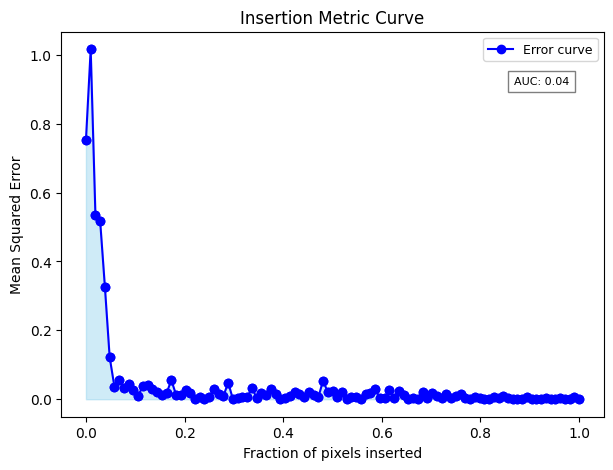

In [171]:
plot_insertion_curve(errors_insertion, auc_insertion)

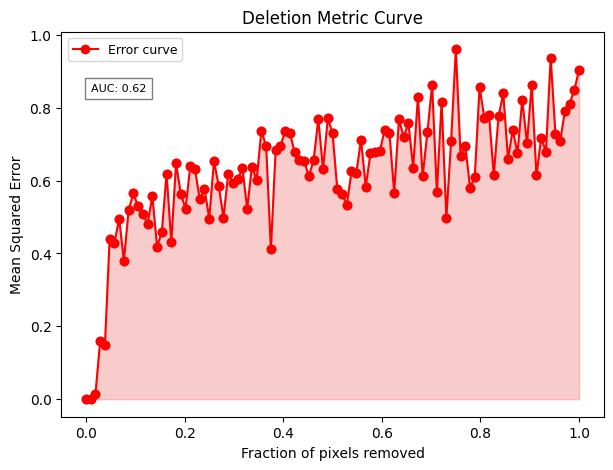

In [172]:
plot_deletion_curve(errors_deletion, auc_deletion)